#### From buoy and AROME data
- Time series plot observed (buoy) and forecast (AROME)
- Generate training and test subset
- OLS on training set
    - OLS corrected predictions
- Get ML corrected predictions
- KS test plots (training, testing, OLS, FNN, xgb)
- QQ & PP plots (training, testing, OLS, FNN, xgb)
- Residual plots (training, testing, OLS, FNN, xgb)


In [1]:
# Import relevant libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
from statsmodels.distributions.empirical_distribution import ECDF

import statsmodels.formula.api as smf 

from ml_correction import add_cyclic_time

import joblib

In [2]:
# Load data - preprocessing
path_data = "../dataset/"
buoys_df = pd.read_csv(f"{path_data}prepared_buoy_data.csv", index_col=[0, 1])

Time Series plot

In [3]:
# Clean and define arrays for buoy of interest
# Buoy 10
kvs_10 = buoys_df.loc['KVS_SvalMIZ_10'].dropna()    # Drop NaN
kvs_10_index = kvs_10.index.values  # Set index (time-date)
kvs_10_t1m = np.array(kvs_10['temp_air'].values)    # Observed air temp at 1m
kvs_10_t2m = np.array(kvs_10['arome_t2m'].values)   # Forecasted air temp at 2m
kvs_10_sic = np.array(kvs_10['sic'].values)         # sea-ice content
# buoy 03
kvs_03 = buoys_df.loc['KVS_SvalMIZ_03'].dropna()    # Drop NaN
kvs_03_index = kvs_03.index.values  # Set index (time-date)
kvs_03_t1m = np.array(kvs_03['temp_air'].values)    # Observed air temp at 1m
kvs_03_t2m = np.array(kvs_03['arome_t2m'].values)   # Forecasted air temp at 2m
kvs_03_sic = np.array(kvs_03['sic'].values)         # sea-ice content
# buoy 07
kvs_07 = buoys_df.loc['KVS_SvalMIZ_07'].dropna()    # Drop NaN
kvs_07_index = kvs_07.index.values  # Set index (time-date)
kvs_07_t1m = np.array(kvs_07['temp_air'].values)    # Observed air temp at 1m
kvs_07_t2m = np.array(kvs_07['arome_t2m'].values)   # Forecasted air temp at 2m
kvs_07_sic = np.array(kvs_07['sic'].values)         # sea-ice content

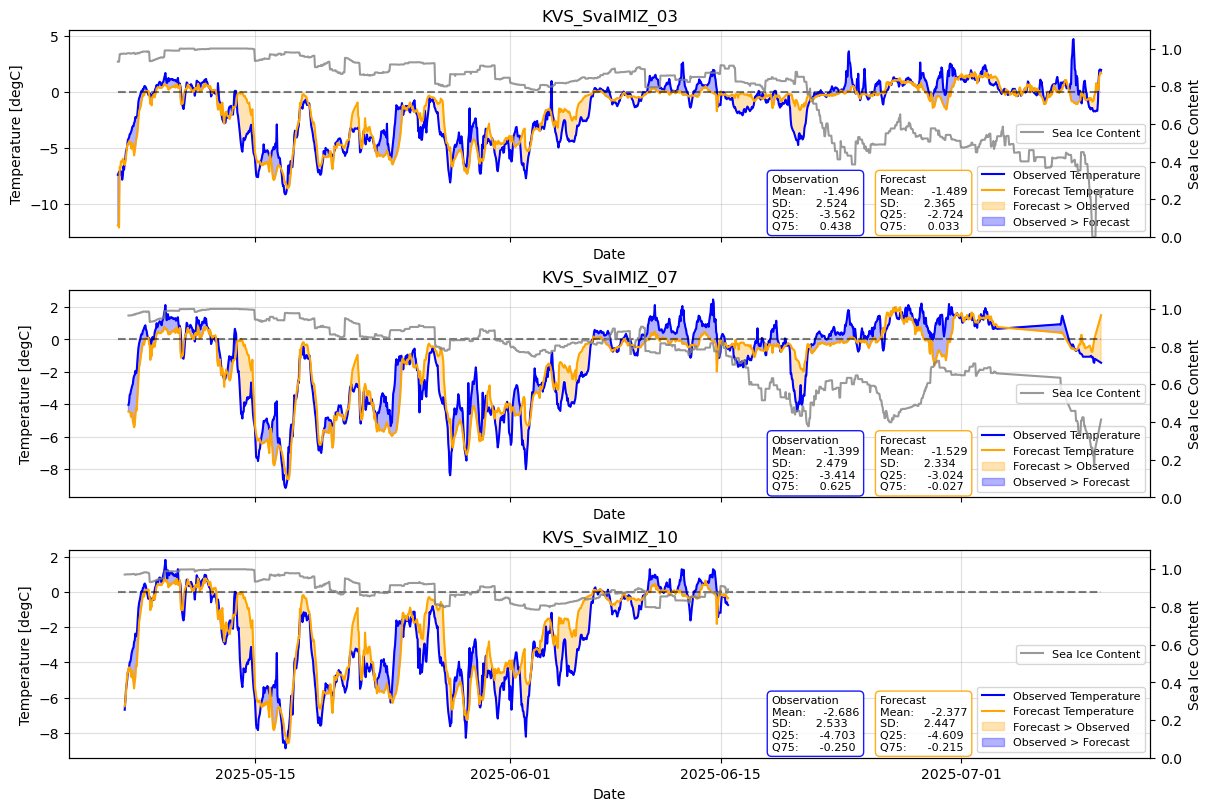

In [4]:
# Time series
t_all=np.concatenate([pd.to_datetime(kvs_03_index), pd.to_datetime(kvs_07_index), pd.to_datetime(kvs_10_index)])
t_min, t_max = t_all.min(), t_all.max()

buoy_index_list =[kvs_03_index, kvs_07_index, kvs_10_index]
buoy_t1m_list = [kvs_03_t1m, kvs_07_t1m, kvs_10_t1m]
buoy_t2m_list = [kvs_03_t2m, kvs_07_t2m, kvs_10_t2m]
buoy_sic_list = [kvs_03_sic, kvs_07_sic, kvs_10_sic]
buoy_name_list = ['KVS_SvalMIZ_03', 'KVS_SvalMIZ_07', 'KVS_SvalMIZ_10']

fig, ax = plt.subplots(nrows = len(buoy_name_list), figsize = (12, 8), sharex=True, constrained_layout=True)
for a in range(len(buoy_name_list)):
    t = pd.to_datetime(buoy_index_list[a])
    obs_mean, obs_std, obs_q25, obs_q75 = buoy_t1m_list[a].mean(), buoy_t1m_list[a].std(), np.percentile(buoy_t1m_list[a], 25), np.percentile(buoy_t1m_list[a], 75)
    est_mean, est_std, est_q25, est_q75 = buoy_t2m_list[a].mean(), buoy_t2m_list[a].std(), np.percentile(buoy_t2m_list[a], 25), np.percentile(buoy_t2m_list[a], 75)

    ax[a].plot(t, buoy_t1m_list[a], label='Observed Temperature', color='blue')
    #ax[a].plot(t, buoy_t1m_list[a] - obs_std, color ='blue', ls=':', alpha=0.8)
    #ax[a].plot(t, buoy_t1m_list[a] + obs_std, color='blue', ls=':', alpha=0.8)
    ax[a].plot(t, buoy_t2m_list[a], label='Forecast Temperature', color='orange')
    above = buoy_t2m_list[a] >= buoy_t1m_list[a]
    below = ~above
    ax[a].fill_between(t, buoy_t1m_list[a], buoy_t2m_list[a], where=above, color='orange',
                         alpha=0.3, interpolate=True, label='Forecast > Observed')
    ax[a].fill_between(t, buoy_t1m_list[a], buoy_t2m_list[a], where=below, color='blue',
                         alpha=0.3, interpolate=True, label='Observed > Forecast')
    ax2 = ax[a].twinx()
    ax2.plot(t, buoy_sic_list[a], color='grey', alpha=0.8, label='Sea Ice Content')


    box_text_obs = (
        f"Observation\n"
        f"Mean:     {obs_mean:.3f}\n"
        f"SD:       {obs_std:.3f}\n"
        f"Q25:      {obs_q25:.3f}\n"
        f"Q75:      {obs_q75:.3f}"
    )
    box_text_est = (
        f"Forecast\n"
        f"Mean:     {est_mean:.3f}\n"
        f"SD:       {est_std:.3f}\n"
        f"Q25:      {est_q25:.3f}\n"
        f"Q75:      {est_q75:.3f}"
    )

    ax[a].text(0.65, 0.3, box_text_obs, transform=ax[a].transAxes, fontsize=8, verticalalignment='top', 
                bbox=dict(boxstyle='round', pad=0.4, facecolor='white', alpha=0.9, edgecolor='blue'))
    ax[a].text(0.75, 0.3, box_text_est, transform=ax[a].transAxes, fontsize=8, verticalalignment='top', 
                bbox=dict(boxstyle='round', pad=0.4, facecolor='white', alpha=0.9, edgecolor='orange'))

    ax[a].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax[a].grid(True, alpha=0.4)
    ax[a].set_ylabel('Temperature [degC]')
    ax[a].set_xlabel('Date')
    ax2.set_ylabel('Sea Ice Content')
    ax2.set_ylim(0,1.1)
    ax[a].set_title(f'{buoy_name_list[a]}')
    ax[a].hlines(0, t_min, t_max, color='k', alpha=0.5, ls='--')

    handles = ax[a].get_legend_handles_labels()[0], ax2.get_legend_handles_labels()[0]
    labels =  ax[a].get_legend_handles_labels()[1], ax2.get_legend_handles_labels()[1]
    ax[a].legend(loc='lower right', fontsize=8)
    ax2.legend(loc='right', fontsize=8)

#fig.suptitle('Time series\nBuoy observations & Forecast')
#fig.tight_layout()
plt.show()


#### Train-test set - OLS

In [ ]:
# Train and test set
train_names=['KVS_SvalMIZ_03', 'KVS_SvalMIZ_07']
train_df = buoys_df.loc[train_names].dropna()
train_df_t1m, train_df_t2m = np.array(train_df['temp_air'].values), np.array(train_df['arome_t2m'].values)
train_df_t1m, train_df_t2m = np.sort(train_df_t1m), np.sort(train_df_t2m)

test_names = ['KVS_SvalMIZ_10']
test_df = buoys_df.loc[test_names].dropna()
test_df_t1m, test_df_t2m = np.array(test_df['temp_air'].values), np.array(test_df['arome_t2m'].values)
test_df_t1m, test_df_t2m = np.sort(test_df_t1m), np.sort(test_df_t2m)

# Convert the datetime index to sin & cos of hod doy
dt=train_df.index.get_level_values(-1)
dt=pd.to_datetime(dt)
train_df['hour'] = dt.hour
train_df['doy'] = dt.dayofyear
train_df=add_cyclic_time(train_df.copy())

dt=test_df.index.get_level_values(-1)
dt=pd.to_datetime(dt)
test_df['hour']=dt.hour
test_df['doy']=dt.dayofyear
test_df=add_cyclic_time(test_df.copy())

In [ ]:
# Fit OLS model on train set
fit1=smf.ols(formula='temp_air ~  sic + hour_cos + hour_sin + day_sin + day_cos + arome_t2m', data=train_df).fit()
#print(np.sqrt(fit1.mse_resid))

# Predict on test set
test_df['ols_temp'] =fit1.params[0] +fit1.params[1] * test_df['sic'] + fit1.params[2] * test_df['hour_cos'] + \
                            fit1.params[3] * test_df['hour_sin'] + fit1.params[4] * test_df['day_sin'] + \
                            fit1.params[5] * test_df['day_cos'] + fit1.params[6] * test_df['arome_t2m']

alpha=0.05  # Significance level

#Calculate RMSE of forecast and observed for
# Train set
rmse_arome_train = np.sqrt(((train_df['temp_air'] - train_df['arome_t2m'])**2).mean())
lower_rmse_arome_train = np.sqrt(train_df.shape[0]/(stats.chi2.ppf(1-alpha/2,train_df.shape[0])))*rmse_arome_train
upper_rmse_arome_train = np.sqrt(train_df.shape[0]/(stats.chi2.ppf(alpha/2,train_df.shape[0])))*rmse_arome_train
# Test set
rmse_arome=np.sqrt(((test_df['temp_air'] - test_df['arome_t2m'])**2).mean())
lower_rmse_arome = np.sqrt(test_df.shape[0]/(stats.chi2.ppf(1-alpha/2,test_df.shape[0])))*rmse_arome
upper_rmse_arome = np.sqrt(test_df.shape[0]/(stats.chi2.ppf(alpha/2,test_df.shape[0])))*rmse_arome
# OLS bias corrected
rmse_ols=np.sqrt(((test_df['temp_air'] - test_df['ols_temp'])**2).mean())
lower_rmse_ols =np.sqrt(test_df.shape[0]/(stats.chi2.ppf(1-alpha/2,test_df.shape[0])))*rmse_ols
upper_rmse_ols = np.sqrt(test_df.shape[0]/(stats.chi2.ppf(alpha/2,test_df.shape[0])))*rmse_ols

# Print RMSE
print(f'RMSE AROME Training: {rmse_arome_train:.5f}')
print(f'Lower limit: {lower_rmse_arome_train:.5f} ({(rmse_arome_train-lower_rmse_arome_train):.5f})\nUpper limit: {upper_rmse_arome_train:.5f} ({(upper_rmse_arome_train-rmse_arome_train):.5f})\n')

print(f'RMSE AROME Testing: {rmse_arome:.5f}')
print(f'Lower limit: {lower_rmse_arome:.5f} ({(rmse_arome-lower_rmse_arome):.5f})\nUpper limit: {upper_rmse_arome:.5f} ({(upper_rmse_arome-rmse_arome):.5f})\n')

print(f'Test data OLS RMSE: {rmse_ols:.5f}')
print(f'Lower limit: {lower_rmse_ols:.5f} ({(rmse_ols-lower_rmse_ols):.5f})\nUpper limit: {upper_rmse_ols:.5f} ({(upper_rmse_ols-rmse_ols):.5f})\n')

print(f'Len training: {train_df.shape[0]} ({100*train_df.shape[0] / (train_df.shape[0]+test_df.shape[0]):.2f}%)')
print(f'Len test: {test_df.shape[0]}({100*test_df.shape[0] / (train_df.shape[0]+test_df.shape[0]):.2f}%)')

RMSE AROME Training: 1.20346
Lower limit: 1.17345 (0.03001)
Upper limit: 1.23505 (0.03159)

RMSE AROME Testing: 1.27077
Lower limit: 1.21647 (0.05430)
Upper limit: 1.33018 (0.05941)

Test data OLS RMSE: 1.19389
Lower limit: 1.14287 (0.05102)
Upper limit: 1.24971 (0.05582)

Len training: 2936 (75.30%)
Len test: 963(24.70%)


#### Post Processing

In [ ]:
# Load bias corrected data from ML corrections
buoy10_df_post = pd.read_csv(f"{path_data}buoy_10_w_models.csv", index_col=[0, 1])
ols_temp_df = test_df.copy().reset_index(level=0, drop=True)
# Attach OLS correction to test data df
buoy10_df_post['ols_temp']=ols_temp_df['ols_temp'].values
buoy10_df_post=buoy10_df_post.reset_index(level=1)
joblib.dump(buoy10_df_post, "buoy10_df_post.joblib")
#buoy10_df_post.head()

['buoy10_df_post.joblib']

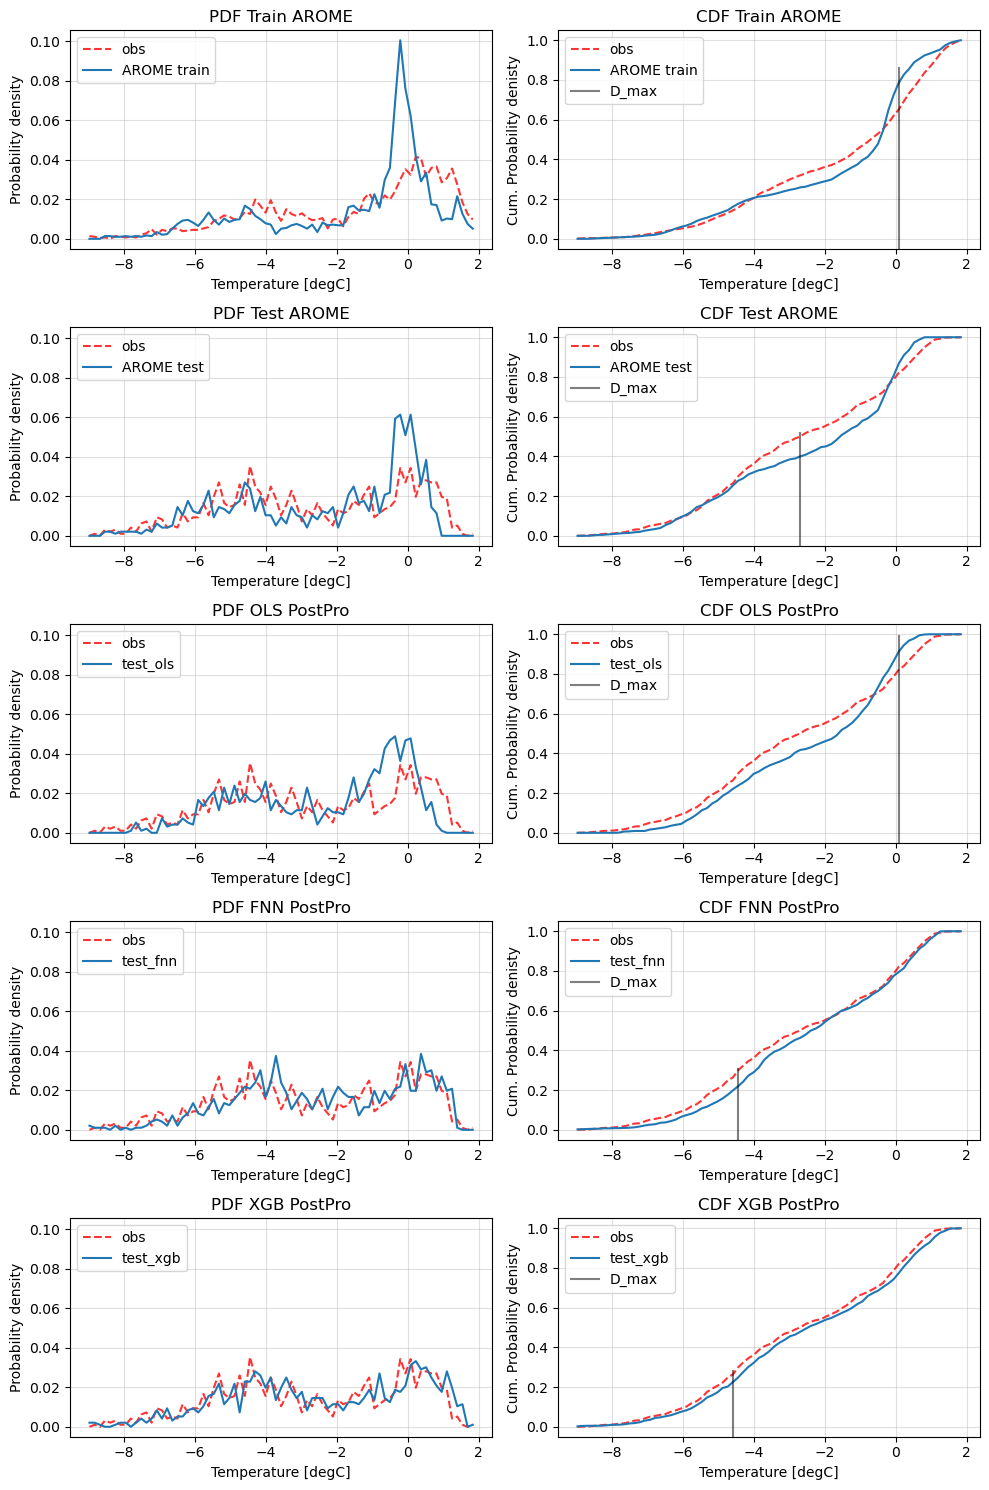

In [ ]:
# KS w/ histograms
# Pre Processing data
train_t1m, train_t2m = np.array(train_df['temp_air'].values), np.array(train_df['arome_t2m'].values)
test_t1m, test_t2m = np.array(test_df['temp_air'].values), np.array(test_df['arome_t2m'].values)
pre_all_temp = np.concatenate([train_t1m, train_t2m, test_t1m, test_t2m])
#pre_all_temp_list = [train_t1m, train_t2m, test_t1m, test_t2m]

# Post Processing data (on test buoy)
test_ols = np.array(buoy10_df_post['ols_temp'].values)
test_nn, test_fnn = np.array(buoy10_df_post['NN_temp'].values), np.array(buoy10_df_post['FNN_temp'].values)
test_xgb, test_xgbdo, test_xgbpo= np.array(buoy10_df_post['xgb_temp'].values), np.array(buoy10_df_post['xgbdo_temp'].values), np.array(buoy10_df_post['xgbpo_temp'].values)
post_all_temp = np.concatenate([test_t1m, test_t2m, test_ols, test_nn, test_fnn,test_xgb, test_xgbdo, test_xgbpo])
#post_all_temp_list = [test_t1m, test_t2m, test_ols,test_nn, test_fnn,test_xgb, test_xgbdo, test_xgbpo]

# Combine all datasets to put in one plot
all_temp = np.concatenate([train_t1m, train_t2m, test_t1m, test_t2m, test_ols, test_fnn, test_xgb]) # test_nn, test_xgbdo, test_xgbpo
bin_edges=np.linspace(post_all_temp.min(), post_all_temp.max(), 76) # affects x-axis of plots

all_temp_titles = ['Train obs', 'Train AROME', 'Test obs', 'Test AROME', 'OLS PostPro', 'FNN PostPro', 'XGB PostPro'] #'NN PostPro', 'XGB_do PostPro', 'XGB_po PostPro'
all_temp_names=['train_t1m', 'train_t2m', 'test_t1m', 'test_t2m', 'test_ols','test_fnn', 'test_xgb'] # 'test_nn', 'test_xgbdo', 'test_xgbpo'
all_temp_list=[train_t1m, train_t2m, test_t1m, test_t2m, test_ols, test_fnn,test_xgb] #test_nn, test_xgbdo, test_xgbpo

# Prepare pdfs and cdfs
pdfs=[]
cdfs=[]

# Calc pdfs and cdfs
for temp in range(len(all_temp_names)):
    counts,_=np.histogram(all_temp_list[temp], bins=bin_edges, density=True)
    pdf=counts/sum(counts)
    pdfs.append(pdf)
    cdfs.append(np.cumsum(pdf))

fig, ax = plt.subplots(nrows=len(all_temp_names)-2, ncols=2, sharey='col', figsize=(10,15) )

# Prepare to store maximum deviations for KS-test
d_nm_all = []
loc_d_all = []

# For train and test data
d_nm_train, d_nm_test = np.max(np.abs(cdfs[1]-cdfs[0])), np.max(np.abs(cdfs[3]-cdfs[2]))
d_nm_all.append(d_nm_train), d_nm_all.append(d_nm_test)

loc_d_train, loc_d_test = np.argmax(np.abs(cdfs[1]-cdfs[0])), np.argmax(np.abs(cdfs[3]-cdfs[2]))
loc_d_all.append(loc_d_train), loc_d_all.append(loc_d_test)

# Plot train set
ax[0,0].plot(bin_edges[1:], pdfs[0], ls='--', c='red', alpha=0.8, label='obs')
ax[0,1].plot(bin_edges[1:], cdfs[0], ls='--', c='red', alpha=0.8, label='obs')    
ax[0,0].plot(bin_edges[1:], pdfs[1], label='AROME train')
ax[0,1].plot(bin_edges[1:], cdfs[1], label='AROME train')
ax[0,0].set_title(f'PDF {all_temp_titles[1]}')
ax[0,1].set_title(f'CDF {all_temp_titles[1]}')
if cdfs[1][loc_d_train] > cdfs[0][loc_d_train]:
    ax[0,1].axvline(bin_edges[loc_d_train], ymin=0, ymax=cdfs[1][loc_d_train], alpha=0.5, c='k', label='D_max')
else:
    ax[0,1].axvline(bin_edges[loc_d_train], ymin=0, ymax=cdfs[0][loc_d_train], alpha=0.5, c='k', label='D_max')

# Plot test set
ax[1,0].plot(bin_edges[1:], pdfs[2], ls='--', c='red', alpha=0.8, label='obs')
ax[1,1].plot(bin_edges[1:], cdfs[2], ls='--', c='red', alpha=0.8, label='obs')    
ax[1,0].plot(bin_edges[1:], pdfs[3], label='AROME test')
ax[1,1].plot(bin_edges[1:], cdfs[3], label='AROME test')
ax[1,0].set_title(f'PDF {all_temp_titles[3]}')
ax[1,1].set_title(f'CDF {all_temp_titles[3]}')
if cdfs[3][loc_d_test] > cdfs[2][loc_d_test]:
    ax[1,1].axvline(bin_edges[loc_d_test], ymin=0, ymax=cdfs[3][loc_d_test], alpha=0.5, c='k', label='D_max')
else:
    ax[1,1].axvline(bin_edges[loc_d_test], ymin=0, ymax=cdfs[2][loc_d_test], alpha=0.5, c='k', label='D_max')

for a in range(2):
    ax[a,0].set_xlabel('Temperature [degC]')
    ax[a,1].set_xlabel('Temperature [degC]')
    ax[a,0].set_ylabel('Probability density')
    ax[a,1].set_ylabel('Cum. Probability denisty')
    ax[a,0].grid(True, alpha=0.4)
    ax[a,1].grid(True, alpha=0.4)
    ax[a,0].legend(loc='upper left')
    ax[a,1].legend(loc='upper left')

# Plot for bias corrected data
for temp in range(4,len(all_temp_list)):
    d_nm = np.max(np.abs(cdfs[temp]-cdfs[2]))
    loc_d = np.argmax(np.abs(cdfs[temp]-cdfs[2]))
    
    d_nm_all.append(d_nm), loc_d_all.append(loc_d)

    ax[temp-2,0].plot(bin_edges[1:], pdfs[2], ls='--', c='red', alpha=0.8, label='obs')
    ax[temp-2,1].plot(bin_edges[1:], cdfs[2], ls='--', c='red', alpha=0.8, label='obs')

    ax[temp-2,0].plot(bin_edges[1:], pdfs[temp], label=all_temp_names[temp])
    ax[temp-2,1].plot(bin_edges[1:], cdfs[temp], label=all_temp_names[temp])

    if cdfs[temp][loc_d] > cdfs[2][loc_d]:
        ax[temp-2,1].axvline(bin_edges[loc_d], ymin=0, ymax=cdfs[temp][loc_d], alpha=0.5, c='k', label='D_max')
    else:
        ax[temp-2,1].axvline(bin_edges[loc_d], ymin=0, ymax=cdfs[2][loc_d], alpha=0.5, c='k', label='D_max')

    ax[temp-2,0].set_title(f'PDF {all_temp_titles[temp]}')
    ax[temp-2,1].set_title(f'CDF {all_temp_titles[temp]}')

    ax[temp-2,0].set_xlabel('Temperature [degC]')
    ax[temp-2,1].set_xlabel('Temperature [degC]')

    ax[temp-2,0].set_ylabel('Probability density')
    ax[temp-2,1].set_ylabel('Cum. Probability denisty')

    ax[temp-2,0].grid(True, alpha=0.4)
    ax[temp-2,1].grid(True, alpha=0.4)

    ax[temp-2,0].legend(loc='upper left')
    ax[temp-2,1].legend(loc='upper left')
plt.tight_layout()
plt.show()



In [ ]:
# Actual KS-test
# Significance level
alpha = .05 # Significance level
c_a = np.sqrt(-np.log(.5*alpha)*.5) # Critical value 

# Calculate the scalers based on sample size for train, test and bias corrected
all_temp_list_it = all_temp_list.copy()
scaler1 = []
scaler2 = []

# sclaers for train and test
n_train, n_test = all_temp_list_it[0].shape[0], all_temp_list_it[2].shape[0]
scal1_train, scal1_test = np.sqrt((n_train+n_train) / (n_train*n_train)), np.sqrt((n_test+n_test) / (n_test*n_test))
scal2_train, scal2_test = np.sqrt((n_train*n_train) / (n_train+n_train)), np.sqrt((n_test*n_test) / (n_test+n_test))

scaler1.append(scal1_train), scaler1.append(scal1_test), scaler2.append(scal2_train), scaler2.append(scal2_test)
# Scalers for bias corrected
for sample in range(4, len(all_temp_list_it)):
    n=all_temp_list[sample].shape[0]
    scal1=np.sqrt((n+n) / (n*n))
    scal2=np.sqrt((n*n) / (n+n))
    scaler1.append(scal1), scaler2.append(scal2)   

test_names = ['Train AROME', 'Test AROME', 'OLS PostPro', 'FNN PostPro', 'XGB PostPro']
# Print test resuls of KS-test
for n in range(0,len(d_nm_all)):
    # test1
    test1 = d_nm_all[n] > c_a*scaler1[n]
    print(f'Test 1 for {test_names[n]}')
    print(f"Two sample KS test. D_nm = {d_nm_all[n]:.3f}, Critical value: {c_a * scaler1[n]:.3f}, rejected = {test1}")

    # test2
    test2 = scaler2[n] * d_nm_all[n] > c_a
    print(f'Test 2 for {test_names[n]}')
    print(f"Two sample KS test. D_nm = {scaler2[n] * d_nm_all[n]:.3f}, Critical value: {c_a:.3f}, rejected = {test2}\n")
    

Test 1 for Train AROME
Two sample KS test. D_nm = 0.135, Critical value: 0.035, rejected = True
Test 2 for Train AROME
Two sample KS test. D_nm = 5.154, Critical value: 1.358, rejected = True

Test 1 for Test AROME
Two sample KS test. D_nm = 0.109, Critical value: 0.062, rejected = True
Test 2 for Test AROME
Two sample KS test. D_nm = 2.393, Critical value: 1.358, rejected = True

Test 1 for OLS PostPro
Two sample KS test. D_nm = 0.105, Critical value: 0.062, rejected = True
Test 2 for OLS PostPro
Two sample KS test. D_nm = 2.301, Critical value: 1.358, rejected = True

Test 1 for FNN PostPro
Two sample KS test. D_nm = 0.081, Critical value: 0.062, rejected = True
Test 2 for FNN PostPro
Two sample KS test. D_nm = 1.777, Critical value: 1.358, rejected = True

Test 1 for XGB PostPro
Two sample KS test. D_nm = 0.051, Critical value: 0.062, rejected = False
Test 2 for XGB PostPro
Two sample KS test. D_nm = 1.117, Critical value: 1.358, rejected = False



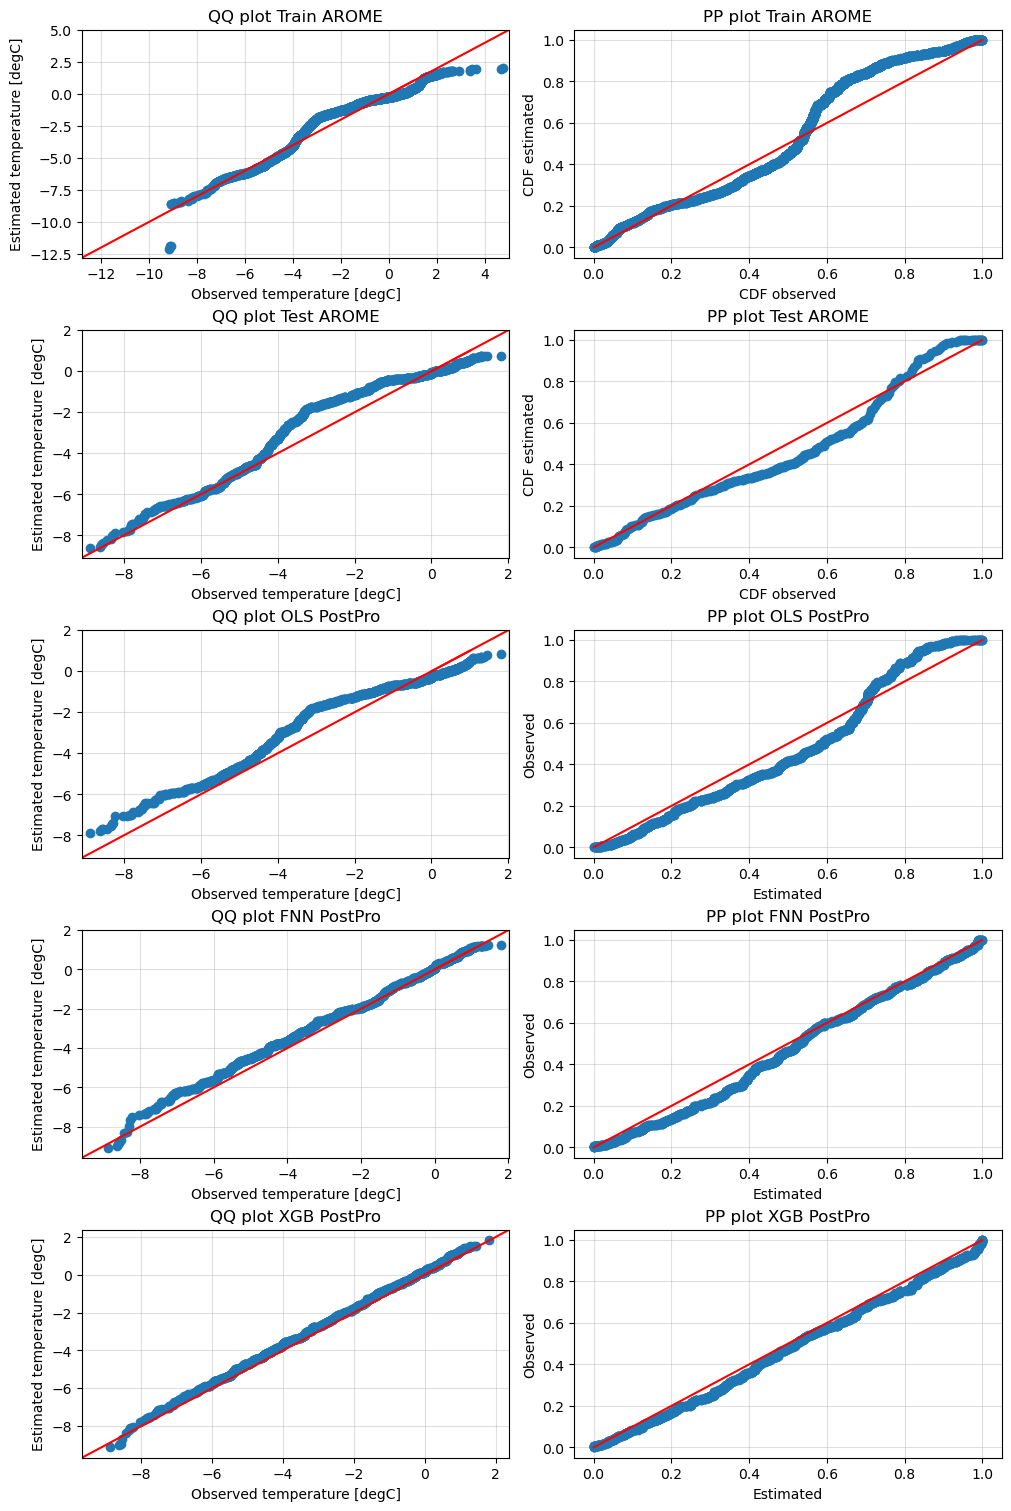

In [ ]:
# QQ & PP plots
# Pre Processing
train_t1m, train_t2m = np.array(train_df['temp_air'].values), np.array(train_df['arome_t2m'].values)
test_t1m, test_t2m = np.array(test_df['temp_air'].values), np.array(test_df['arome_t2m'].values)
pre_all_temp = np.concatenate([train_t1m, train_t2m, test_t1m, test_t2m])

# Post Processing
test_ols = np.array(buoy10_df_post['ols_temp'].values)
test_nn, test_fnn = np.array(buoy10_df_post['NN_temp'].values), np.array(buoy10_df_post['FNN_temp'].values)
test_xgb, test_xgbdo, test_xgbpo= np.array(buoy10_df_post['xgb_temp'].values), np.array(buoy10_df_post['xgbdo_temp'].values), np.array(buoy10_df_post['xgbpo_temp'].values)

# All
all_temp = np.concatenate([train_t1m, train_t2m, test_t1m, test_t2m, test_ols, test_fnn, test_xgb]) # test_nn, test_xgbdo, test_xgbpo

all_temp_titles = ['Train obs', 'Train AROME', 'Test obs', 'Test AROME', 'OLS PostPro', 'FNN PostPro', 'XGB PostPro'] #'NN PostPro', 'XGB_do PostPro', 'XGB_po PostPro'
all_temp_names=['train_t1m', 'train_t2m', 'test_t1m', 'test_t2m', 'test_ols','test_fnn', 'test_xgb'] # 'test_nn', 'test_xgbdo', 'test_xgbpo'
all_temp_list=[train_t1m, train_t2m, test_t1m, test_t2m, test_ols, test_fnn,test_xgb] #test_nn, test_xgbdo, test_xgbpo
all_temp_list = [np.sort(a) for a in all_temp_list]

fig,ax = plt.subplots(nrows=len(all_temp_names)-2, ncols=2, figsize=(10,15), layout='constrained')
# QQ plots
qqplot_2samples(all_temp_list[0], all_temp_list[1], line='45', ax=ax[0,0])
ax[0,0].set_title(f'QQ plot {all_temp_titles[1]}')
qqplot_2samples(all_temp_list[2], all_temp_list[3], line='45', ax=ax[1,0])
ax[1,0].set_title(f'QQ plot {all_temp_titles[3]}')
# PP plots
# Train
F_0_train = ECDF(all_temp_list[0])
F_train = ECDF(all_temp_list[1])
x_train = np.sort(np.unique(np.concatenate([all_temp_list[0], all_temp_list[1]])))
p_0_train = F_0_train(x_train)
p_train = F_train(x_train)
ax[0,1].plot(p_0_train, p_train,'o')
ax[0,1].set_title(f'PP plot {all_temp_titles[1]}')
# Test
F_0_test = ECDF(all_temp_list[2])
F_test = ECDF(all_temp_list[3])
x_test = np.sort(np.unique(np.concatenate([all_temp_list[2], all_temp_list[2]])))
p_0_test = F_0_test(x_test)
p_test = F_test(x_test)
ax[1,1].plot(p_0_test, p_test,'o')
ax[1,1].set_title(f'PP plot {all_temp_titles[3]}')
for a in range(2):
    ax[a,0].set_xlabel('Observed temperature [degC]')
    ax[a,1].set_xlabel('CDF observed')
    ax[a,0].set_ylabel('Estimated temperature [degC]')
    ax[a,1].set_ylabel('CDF estimated')
    ax[a,0].grid(True, alpha=0.4)
    ax[a,1].grid(True, alpha=0.4)
    ax[a,0].plot([0,1], [0,1], c='red')
    ax[a,1].plot([0,1], [0,1], c='red')
    #ax[a,0].legend(loc='upper left')
    #ax[a,1].legend(loc='upper left')


# Plot for bias-corrected data
for a in range(4, len(all_temp_list)):
    # QQ plot
    qqplot_2samples(all_temp_list[2], all_temp_list[a], line='45', ax=ax[a-2,0])

    # PP plot
    F_ = ECDF(all_temp_list[a])
    F_0 = ECDF(all_temp_list[2])
    x=np.sort(np.unique(np.concatenate([all_temp_list[2], all_temp_list[a]])))

    p_=F_(x)
    p_0=F_0(x)

    ax[a-2,1].plot(p_0,p_,'o')
    for b in range(2):
        ax[a-2,b].grid(True, alpha=0.4)
        ax[a-2,b].plot([0,1], [0,1],c='red')
    
    ax[a-2,0].set_title(f'QQ plot {all_temp_titles[a]}')
    ax[a-2,0].set_ylabel(f'Estimated temperature [degC]')
    ax[a-2,0].set_xlabel(f'Observed temperature [degC]')

    ax[a-2,1].set_title(f'PP plot {all_temp_titles[a]}')
    ax[a-2,1].set_ylabel(f'Observed')
    ax[a-2,1].set_xlabel(f'Estimated')

#fig.suptitle('QQ & PP plots')
plt.show()

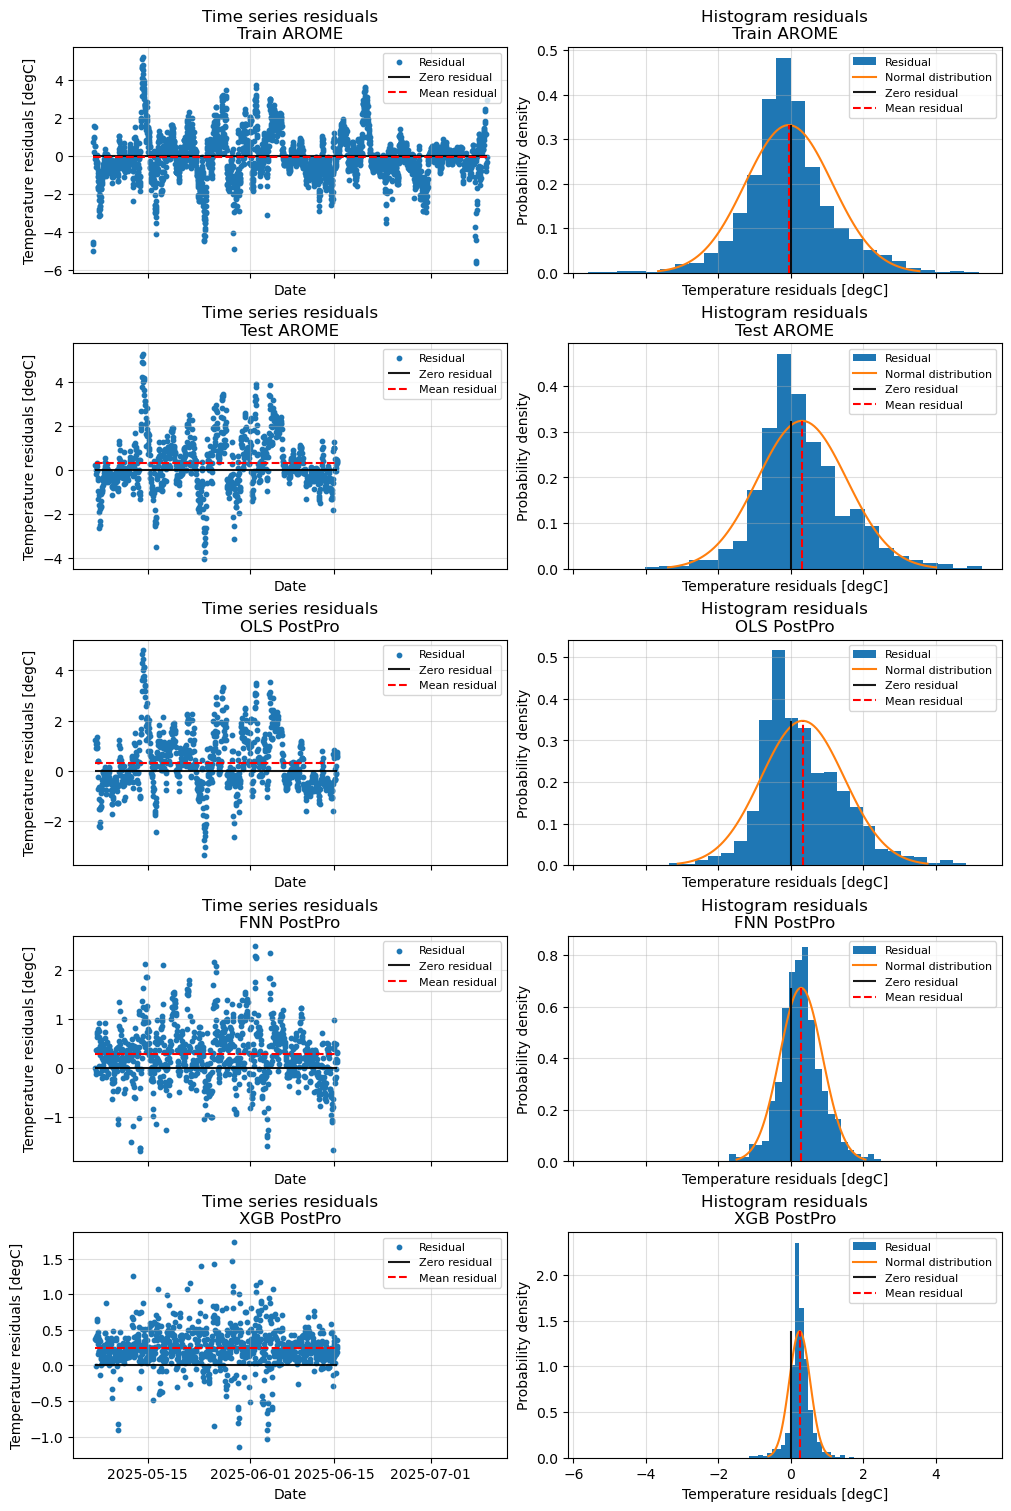

In [ ]:
# Residuals = Estimated - Observed
# For train, test, and bias corrected
all_temp_titles = ['Train obs', 'Train AROME', 'Test obs', 'Test AROME', 'OLS PostPro', 'FNN PostPro', 'XGB PostPro'] #'NN PostPro', 'XGB_do PostPro', 'XGB_po PostPro'
all_temp_names=['train_t1m', 'train_t2m', 'test_t1m', 'test_t2m', 'test_ols','test_fnn', 'test_xgb'] # 'test_nn', 'test_xgbdo', 'test_xgbpo'
all_temp_list=[train_t1m, train_t2m, test_t1m, test_t2m, test_ols, test_fnn,test_xgb] #test_nn, test_xgbdo, test_xgbpo
arome_train_res, arome_test_res = all_temp_list[1] - all_temp_list[0], all_temp_list[3] - all_temp_list[2]
ols_res, fnn_res, xgb_res = [all_temp_list[t] - all_temp_list[2] for t in range(4,len(all_temp_list))]

# Combine residuals in one list
res_list=[arome_train_res, arome_test_res, ols_res, fnn_res, xgb_res]
res_title_list=['Train AROME', 'Test AROME', 'OLS PostPro', 'FNN PostPro', 'XGB PostPro']

fig, ax = plt.subplots(nrows=len(res_list), ncols=2, sharex='col', figsize=(10,15), layout='constrained')
# Plot the residuals over different time periods (ref. original datasets)
for res in range(len(res_list)):
    if res < 1:
        dt = pd.to_datetime(train_df.index.get_level_values(-1))
    elif res < 2:
        dt = pd.to_datetime(test_df.index.get_level_values(-1))
    else:
        dt = pd.to_datetime(buoy10_df_post.index.get_level_values(0))
    
    ax[res,0].scatter(dt, res_list[res], label='Residual', s=10)
    ax[res,0].hlines(0, dt.min(), dt.max(), color='black', alpha=0.9, label='Zero residual')
    ax[res,0].hlines(res_list[res].mean(), dt.min(), dt.max(), color='red', ls='--', label='Mean residual')
    #ax[res,0].hlines([res_list[res].mean()-res_list[res].std(), res_list[res].mean()+res_list[res].std()], dt.min(), dt.max(), color='red', ls=':', label='Std residual')

    ax[res,0].set_title(f'Time series residuals\n{res_title_list[res]}')
    ax[res,0].set_ylabel('Temperature residuals [degC]')
    ax[res,0].set_xlabel('Date')
    ax[res,0].grid(True,alpha=0.4)
    ax[res,0].legend(loc='upper right', fontsize=8)

    mean, sd, n = res_list[res].mean(), res_list[res].std(), res_list[res].shape[0]
    k=int(1+3.3*np.log(n))
    x=np.linspace(mean-3*sd, mean+3*sd, 100)

    ax[res,1].hist(res_list[res], bins=k, density=True, label='Residual')
    ax[res,1].plot(x, stats.norm.pdf(x,loc=mean,scale=sd), label='Normal distribution')

    ax[res,1].grid(True, alpha=0.4)
    ax[res,1].set_title(f'Histogram residuals\n{res_title_list[res]}')
    ax[res,1].set_ylabel('Probability density')
    ax[res,1].set_xlabel('Temperature residuals [degC]')
    ax[res,1].vlines(0,0,stats.norm.pdf(x, loc=mean, scale=sd).max(), color='black', alpha=0.9, label='Zero residual')
    ax[res,1].vlines(mean, 0, stats.norm.pdf(x, loc=mean, scale=sd).max(), ls='--', color='red', label='Mean residual')

    ax[res,1].legend(loc='upper right', fontsize=8)

plt.show()    
